# Model fitting and simulation with the Perceptual Error Adaptation (PEA) model
<br>

**Created by Zhaoran Zhang, 01-2024**
<br>

**Cite**: [Zhang, Z., Wang, H., Zhang, T., Nie, Z., & Wei, K. (2023). Perceptual error based on Bayesian cue combination drives implicit motor adaptation. eLife13:RP94608](https://doi.org/10.7554/eLife.94608.1)
<br>

**Correspondence to**: wei.kunlin at pku.edu.cn
<br>
<br>

Questions about the codes and data, please contact: zhangzhaoran10 at gmail.com
<br>

Download the data from [here](https://doi.org/10.6084/m9.figshare.24503926.v2)
<br>
<br>

### 1. Fitting error-clamp adpatation extent with the PEA model (Figure 1B)

The PEA model predicts that implicit adaptation extent is a concave function of perturbation size, a pattern qualitatively aligning with previous findings 

Data from [Kim et al., 2018](https://doi.org/10.1038/s42003-018-0021-y) and [Morehead et al., 2017](https://doi.org/10.1162/jocn_a_01108)


**Import packages and dataset**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from scipy.optimize import minimize
import warnings

# Turn off runtime warnings
warnings.filterwarnings("ignore")
matplotlib.rcParams['font.family'] = 'Arial'

In [11]:
# Load data
Fig1B = pd.read_csv('Fig1B.csv')

# Names of the studies
T = ['Kim,2018 exp1', 'Kim,2018 exp2', 'Morehead,2017']

# Define fitting function for adaptation extent (see Eq 7)
def PEAEnd(x, s_v, data):
    R1 = x[0]  # sig_h/inter
    R2 = x[1]  # slope/inter
    hand_final = (R1 / (1 + R2 * s_v)) ** 2 * s_v
    RMSE = np.sqrt(np.mean((data - hand_final) ** 2))
    return RMSE


**Data fitting and plot**

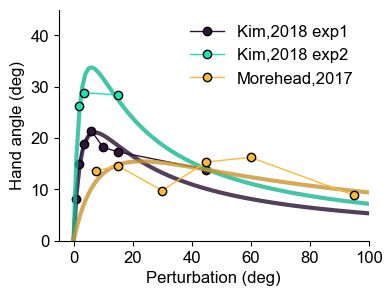

In [12]:
# Define initial values and bounds
ini = [10 / 1.8, 0.3 / 1.8]
LB = [1, 0]
UB = [5, 1]
PLB = LB
PUB = UB

# Perform fitting and plot results
s_v = np.linspace(0, 100, 100)
Studynum = np.unique(Fig1B['study'])

Cols = plt.cm.turbo(np.linspace(0, 1, 4))
fig, ax = plt.subplots(figsize=(4, 3))

for i in range(3):

    # perturbation sizes, mean end values, and titles
    Deg = Fig1B.loc[Fig1B['study'] == Studynum[i], 'perturbSize'].values
    meanEnd = Fig1B.loc[Fig1B['study'] == Studynum[i], 'extent'].values
    Title = T[i]

    func = lambda x: PEAEnd(x, Deg, meanEnd)
    FitParam = None
    fval = float('inf')

    for run in range(100):
        ini_run = [PLB[i] + (PUB[i] - PLB[i]) * np.random.rand() for i in range(len(PLB))]
        res = minimize(func, ini_run, bounds=list(zip(LB, UB)),method='Nelder-Mead')
        if res.fun < fval:
            FitParam = res.x
            fval = res.fun
    
    R1 = FitParam[0]
    R2 = FitParam[1]

    PEA_ext = (R1 / (1 + R2 * s_v)) ** 2 * s_v
    simuData = (R1 / (1 + R2 * Deg)) ** 2 * Deg
    SSres = np.sum((simuData - meanEnd) ** 2)
    SStot = np.sum((meanEnd - np.nanmean(meanEnd)) ** 2)
    Rsquared = 1 - SSres / SStot
    RMS = np.sqrt(np.nanmean((simuData - meanEnd) ** 2))
    ax.plot(s_v, PEA_ext, color=Cols[i] * 0.8, linewidth=3)
    ax.plot(Deg, meanEnd, '-o', markerfacecolor=Cols[i], markeredgecolor='k', 
    linewidth=1, color=Cols[i], markersize=6, label=Title)

ax.set_xlim(-5, 100)
ax.set_ylim(0, 45)
ax.set_xlabel('Perturbation (deg)', fontsize=12)
ax.set_ylabel('Hand angle (deg)', fontsize=12)
ax.set_xticks(np.arange(0, 101, 20))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(axis='both', labelsize=12)
ax.legend(fontsize=12, loc='upper right',frameon=False)

plt.show()

### 2. Fitting block-designed error-clamp adaptation with the PEA model (Figure 3)

**Import dataset**

In [4]:
data = pd.read_csv("Exp2.csv")

Deg = data['perturbSize'].unique()
group, perturb, sub, type, Num, hand = data['group'], data['perturbSize'], data['sub'], data['trialType'], data['cycleNum'], data['handangle']

alldata = []
Base = []
Data = []
Pertur = []

for g in range(len(Deg)):
    alldata.append(hand[group==g+1].values.reshape(-1, 120))
    Base.append(np.nanmean(alldata[g][:,20:30], axis=1))
    Data.append(np.nanmean(alldata[g] - Base[g].reshape(-1, 1), axis=0))
    Pertur.append(np.concatenate((np.zeros(30), np.ones(80) * Deg[g], np.nan*np.zeros(10))))

FitRange = [30, 120]

**Define functions**

In [5]:
def SE(Data, dim=1):
    if dim == 1:
        e = np.nanstd(Data, axis=0) / np.sqrt(np.sum(~np.isnan(Data), axis=0))
    elif dim == 2:
        e = np.nanstd(Data, axis=1) / np.sqrt(np.sum(~np.isnan(Data), axis=1))
    return e

def PEATbT_fitting(param, Pertur, Data, FitRange):
    # objective function for fitting
    sError = []
    for Group in range(len(Data)):
        pertur = Pertur[Group]
        data = Data[Group]
        Index = FitRange[0]
        Index2 = FitRange[1]
        Hand_real = PEATbT(param, pertur, len(data))
        sError.extend((Hand_real[Index:Index2] - data[Index:Index2])**2)
    RMSE = np.sqrt(np.nanmean(sError))
    return RMSE

def PEATbT(param, pertur, trialNum):
    a = param[0] # retention rate
    b = param[1] # learning rate
    sig_h = param[2] # proprioceptive variance
    sig_g = param[3] # sensory predition variance
    slope = param[4] # slope of visual uncertainty
    intercept = param[5] # intercept of visual uncertainty
    s_g = 0
    Hand_real = np.zeros(trialNum)
    Hand_est = np.zeros(trialNum)

    for t in range(trialNum):
        s_v = -pertur[t]
        sig_v = (slope * pertur[t] + intercept)**2
        s_h = Hand_real[t]
        if not np.isnan(s_v):
            c_mean, _ = CueCombine(s_h, s_v, s_g, sig_h, sig_v, sig_g)
        else:
            c_mean, _ = CueCombine(s_h, s_g, 0, sig_h, sig_g, 0, 1)
        Hand_est[t] = c_mean
        if t < trialNum - 1:
            Hand_real[t+1] = a * Hand_real[t] + b * (0 - Hand_est[t])
    return Hand_real

def CueCombine(s_1, s_2, s_3, sig_1, sig_2, sig_3, twocues=None):
    s_12 = s_1 + 1 / (sig_2 / sig_1 + 1) * (s_2 - s_1)
    sig_12 = sig_2 * sig_1 / (sig_2 + sig_1)
    s_123 = s_12 + 1 / (1 + sig_3 / sig_12) * (s_3 - s_12)
    sig_123 = sig_12 * sig_3 / (sig_12 + sig_3)
    c_mean = s_123
    c_sig = sig_123
    if twocues == 1:
        c_mean = s_12
        c_sig = sig_12
    return c_mean, c_sig

**Fit block-designed dataset**

Note: since there is no equivalent optimization algorithm in Python to replace *fmincon* in Matlab. 
<br>
The fitting result could be slightly different from the paper, depends on the choice of algorithm and number of runs.

In [6]:
# set the bounds for fitting
# LB = [0, 0, 0, 0, 0.309, 1.853]
# UB = [1, 1, 200, 200, 0.309, 1.853]
LB = [0, 0, 0, 0, 0.1, 0.1]
UB = [1, 1, 200, 200, 10, 10]

# choose initial values for fitting
# PLB = [0.8, 0.05, 25, 5, 0.309, 1.853]
# PUB = [0.99, 0.4, 180, 100, 0.309, 1.853]
PLB = [0.8, 0.05, 25, 5, 0.1, 0.1]
PUB = [0.99, 0.4, 180, 100, 1, 5]

func = lambda x: PEATbT_fitting(x, Pertur, Data,FitRange)
FitParam = None
fval = float('inf')

for run in range(10):
    ini_run = [PLB[i] + (PUB[i] - PLB[i]) * np.random.rand() for i in range(len(PLB))]
    res = minimize(func, ini_run, bounds=list(zip(LB, UB)),method='Nelder-Mead')
    if res.fun < fval:
        FitParam = res.x
        fval = res.fun

print(f"A = {FitParam[0]:.3f}\nB = {FitParam[1]:.3f}\nsigma_p= {np.sqrt(FitParam[2]):.3f}\
      \nsigma_u= {np.sqrt(FitParam[3]):.3f}\nSlope= {FitParam[4]:.3f}\nIntercept= {FitParam[5]:.3f}")

Hand_real = np.zeros((len(Deg), len(Data[0])))
for g in range(len(Deg)):
    Hand_real[g] = PEATbT(FitParam, Pertur[g], len(Data[g]))
SSres = np.sum((Hand_real[:, FitRange[0]:FitRange[1]] - np.array(Data)[:, FitRange[0]:FitRange[1]])**2)
SStot = np.sum((np.array(Data) - np.nanmean(np.array(Data)))**2)
Rsquared = 1 - SSres / SStot
RMS = np.sqrt(np.nanmean(np.nanmean((Hand_real[:, FitRange[0]:FitRange[1]]-np.array(Data)[:, FitRange[0]:FitRange[1]])**2)))
TrialNum = np.arange(1, Hand_real.shape[1]+1)

deg = np.arange(0, 101)
HandSimu = np.zeros(len(deg))
for g in range(len(deg)):
    angle = deg[g]
    pertur = np.ones(80) * angle
    hand_real = PEATbT(FitParam, pertur, 80)
    HandSimu[g] = np.nanmean(hand_real[-10:])



A = 0.971
B = 0.194
sigma_p= 4.729      
sigma_u= 2.132
Slope= 0.129
Intercept= 0.653


**Plot data and fitting results of the PEA model**

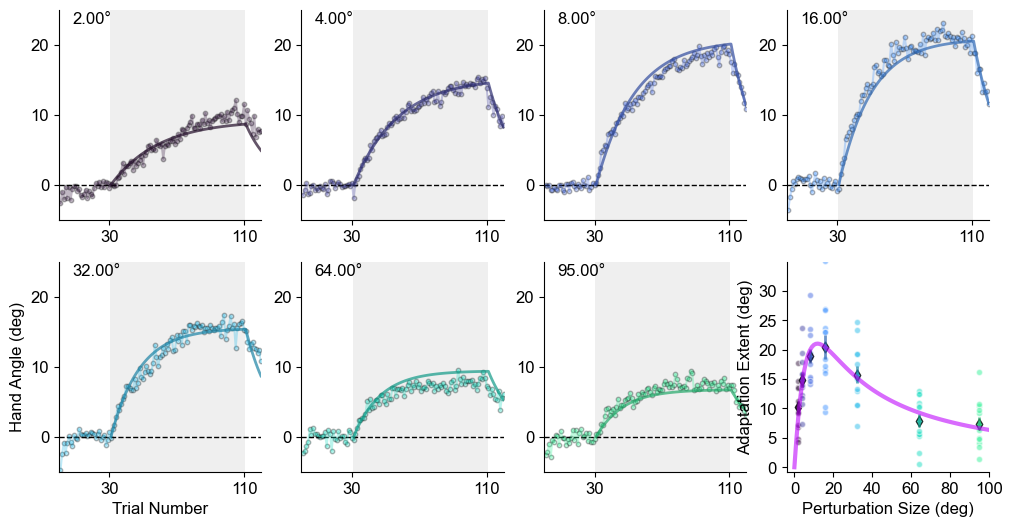

In [7]:
Cols = plt.cm.turbo(np.linspace(0, 1, len(Deg)+10))
fig = plt.figure(figsize=(12, 6))

for g in range(len(Deg)):
    ax = fig.add_subplot(2, 4, g+1)
    ax.text(8, 23, f'{Deg[g]:.2f}°', fontsize=12)
    ax.plot([0, 150], [0, 0], color='black', linewidth=1, linestyle='--')
    ax.fill_between([30.5, 110.5], [-10, -10], [25, 25], color=[0.7, 0.7, 0.7], alpha=0.2, edgecolor='none')
    ax.scatter(TrialNum, Data[g], 10, Cols[g], marker='o', facecolors=Cols[g], edgecolors='k', alpha=0.3)
    ax.plot(TrialNum, Data[g], color=Cols[g], alpha=0.3)
    ax.plot(TrialNum[FitRange[0]:FitRange[1]], Hand_real[g, FitRange[0]:FitRange[1]], color=Cols[g]*0.7, linewidth=2)
    ax.plot(TrialNum[FitRange[1]:], Hand_real[g, FitRange[1]:], color=Cols[g]*0.7, linewidth=2, linestyle='--')
    ax.set_xlim(0, 120)
    ax.set_ylim(-5, 25)
    if g==4:
        ax.set_xlabel('Trial Number', fontsize=12)
        ax.set_ylabel('Hand Angle (deg)', fontsize=12)
    ax.set_xticks([30, 110])
    ax.set_yticks(np.arange(0, 26, 10))
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.tick_params(axis='both', labelsize=12)

ax = fig.add_subplot(2, 4, 8)
ax.set_xlabel('Perturbation Size (deg)', fontsize=12)
ax.set_ylabel('Adaptation Extent (deg)', fontsize=12)
ax.set_xticks(np.arange(0, 101, 20))
ax.set_yticks(np.arange(0, 31, 5))
ax.tick_params(axis='both', labelsize=12)
ax.set_xlim(-4, 100)
ax.set_ylim(-0.75, 35)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


for g in range(7):
    EndData = np.nanmean(alldata[g][:, 100:109] - Base[g].reshape(-1, 1), axis=1)
    for s in range(12):
        ax.scatter(Deg[g], EndData[s], 20, Cols[g], marker='o', facecolors=Cols[g], edgecolors='w', alpha=0.5)
    ax.scatter(Deg[g], np.nanmean(EndData), 30, Cols[g], marker='d', facecolors=Cols[g], 
               edgecolors='k', alpha=0.8)
    ax.errorbar(Deg[g], np.nanmean(EndData), SE(EndData), capsize=0, color=Cols[g]*0.7, linewidth=2)
ax.plot(deg, HandSimu, linewidth=3, color=np.array([190, 3, 252, 150])/255)

plt.show()

### 3. Simulation of proprioceptive bias and results from Experiment 3. (Figure 4B, 4C and 4E) 

**Import dataset and define functions**

In [8]:
# Import data of Exp 3
data = pd.read_csv("Exp3.csv")
Deg = [10, 20, 40, 80]

perturb = data["perturbSize"]
sub = data["sub"]
Num = data["trialNum"]
propBias = data["propBias"]

Data1 = propBias[Num == 1].values.reshape(-1, 4)
Data2 = propBias[Num == 2].values.reshape(-1, 4)
Data3 = propBias[Num == 3].values.reshape(-1, 4)

def PEATbTProp(param, pertur, trialNum):
    # simulate proprioceptive bias with the PEA model
    Hand_real = np.zeros(trialNum)
    Hand_est = np.zeros(trialNum)
    Hand_est2 = np.zeros(trialNum)
    a = param[0]
    b = param[1]
    s_g = 0
    sig_h = param[2]
    sig_g = param[3]
    slope = param[4]
    intercept = param[5]

    for t in range(trialNum):
        s_v = -pertur[t]
        sig_v = (slope * pertur[t] + intercept) ** 2
        s_h = Hand_real[t]
        if not np.isnan(s_v):
            c_mean, c_sig_sq = CueCombine(s_h, s_v, s_g, sig_h, sig_v, sig_g)
        else:
            c_mean, c_sig_sq = CueCombine(s_h, s_g, 0, sig_h, sig_g, 0, 1)

        c_mean2, _ = CueCombine(c_mean, 0, 0, c_sig_sq, sig_h, 0, 1)
        Hand_est2[t] = c_mean2
        Hand_est[t] = c_mean

        if t < trialNum - 1:
            Hand_real[t + 1] = a * Hand_real[t] + b * (0 - Hand_est[t])

    return Hand_real, Hand_est

def CueCombine(s_1, s_2, s_3, sig_1, sig_2, sig_3, twocues=None):
    s_12 = s_1 + 1 / (sig_2 / sig_1 + 1) * (s_2 - s_1)
    sig_12 = sig_2 * sig_1 / (sig_2 + sig_1)
    s_123 = s_12 + 1 / (1 + sig_3 / sig_12) * (s_3 - s_12)
    sig_123 = sig_12 * sig_3 / (sig_12 + sig_3)
    c_mean = s_123
    c_sig = sig_123
    if twocues == 1:
        c_mean = s_12
        c_sig = sig_12

    return c_mean, c_sig


def PReMoTbTProp(x, s_v, trialNum):
    # simulate proprioceptive bias with the PReMo model
    a = x[0]
    b = x[1] 
    eta = x[2]
    sat = x[3]
    B = x[4]
    A = x[5]
    Hand_real = np.zeros(trialNum)
    xper = np.zeros(trialNum)
    xv = -s_v
    for i in range(trialNum):
        xp = Hand_real[i]
        if abs(xv[i]) == 1000:
            xper[i] = xp
        elif not np.isnan(xv[i]):
            beta = -min([sat, abs(eta * (a * xv[i] - b * xp))])
            xper[i] = beta + xp * b
        else:
            xper[i] = b * xp
        if i < trialNum - 1:
            Hand_real[i + 1] = A * Hand_real[i] + B * (0 - xper[i])
    Hand_est = xper
    return Hand_real, Hand_est

**Plot data of Exp 3 and simulate proprioceptive bias with PEA model and [PReMo model](https://doi.org/10.7554/eLife.76639)**

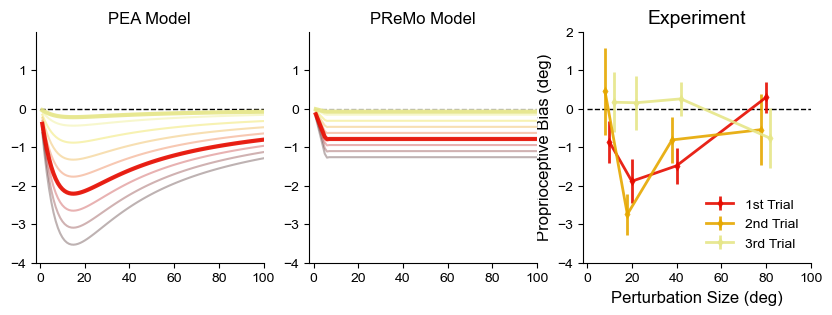

In [9]:
Cols_ = plt.cm.hot(np.linspace(0, 1, 40)) * 0.9
Cols = Cols_[:40, :]

Axis = [-2, 100, -4, 2]
fig = plt.figure(figsize=(10, 3))

# Experiment data
ax = fig.add_subplot(1, 3, 3)
ax.set_xlabel('Perturbation Size (deg)', fontsize=12)
ax.set_ylabel('Proprioceptive Bias (deg)', fontsize=12)
ax.set_xticks(range(0, 101, 20))
ax.set_yticks(range(-4, 3))
ax.set_xlim(Axis[0], Axis[1])
ax.set_ylim(Axis[2], Axis[3])
ax.set_title('Experiment', fontsize=14)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.plot([0, 100], [0, 0], color='black', linestyle='--', linewidth=1)
Leg = []
Leg.append(ax.errorbar(Deg, Data1.mean(axis=0), Data1.std(axis=0) / Data1.shape[0] ** 0.5, capsize=0, color=Cols[15], linewidth=2,
                        marker='d', markerfacecolor=Cols[15], markeredgecolor='none', markersize=5))
Leg.append(ax.errorbar([x - 2 for x in Deg], Data2.mean(axis=0), Data2.std(axis=0) / Data2.shape[0] ** 0.5, capsize=0, color=Cols[25],
                        linewidth=2, marker='d', markerfacecolor=Cols[25], markeredgecolor='none', markersize=5))
Leg.append(ax.errorbar([x + 2 for x in Deg], Data3.mean(axis=0), Data3.std(axis=0) / Data3.shape[0] ** 0.5, capsize=0, color=Cols[35],
                        linewidth=2, marker='d', markerfacecolor=Cols[35], markeredgecolor='none', markersize=5))
ax.legend(Leg, ['1st Trial', '2nd Trial', '3rd Trial'], fontsize=10, loc='lower right', frameon=False)

# simulation from the PEA model
fitParam = [0.2, 0.97, 11.19**2, 5.048**2, 0.309, 1.853, 0.4]
deg = list(range(1, 101))
Tn = 100
Ratios = [0.05] + [0.1 * i for i in range(1, 9)]
HandEstSimuAll = []
for r in range(len(Ratios)):
    temp = []
    for g in range(len(deg)):
        angle = deg[g]
        pertur = [angle] * Tn
        hand_real, hand_est = PEATbTProp(fitParam, pertur, Tn)
        temp.append(hand_est[5]*Ratios[r])
    HandEstSimuAll.append(temp)
ax = fig.add_subplot(1, 3, 1)
ax.set_xticks(range(0, 101, 20))
ax.set_yticks(range(-4, 2))
ax.set_xlim(Axis[0], Axis[1])
ax.set_ylim(Axis[2], Axis[3])
ax.set_title('PEA Model', fontsize=12)
ax.plot([0, 100], [0, 0], color='black', linestyle='--', linewidth=1)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
L1 = 35
L2 = 15
itv = (L1 - L2) / (0.5 - 0.05)
Step = L1 - np.round((np.array(Ratios) - 0.05) * itv)
ccols = Cols[Step.astype(int), :]
for i in range(len(HandEstSimuAll)):
    ax.plot(deg, HandEstSimuAll[i], color=ccols[i, :], linewidth=1.5, linestyle='-',alpha=0.3)
ax.plot(deg, HandEstSimuAll[5], color=Cols[L2, :], linewidth=3,alpha=0.9)
ax.plot(deg, HandEstSimuAll[0], color=Cols[L1, :], linewidth=3,alpha=0.9)

# Simulation from the PReMo model
fitParam = [0.4361, 0.1424, 0.7238, 2.0756, 0.3774, 0.9987]
Prop = np.zeros((len(Ratios), len(deg)))
for j in range(len(Ratios)):
    R = Ratios[j]
    for i in range(len(deg)):
        s_v = np.ones(Tn) * deg[i]
        Hand_real, Hand_est = PReMoTbTProp(fitParam, s_v, Tn)
        Prop[j, i] = R * Hand_est[5]

ax = fig.add_subplot(1, 3, 2)
ax.set_xticks(range(0, 101, 20))
ax.set_yticks(range(-4, 2))
ax.set_xlim(Axis[0], Axis[1])
ax.set_ylim(Axis[2], Axis[3])
ax.set_title('PReMo Model', fontsize=12)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.plot([0, 100], [0, 0], color=[0, 0, 0, 0.3], linestyle='--', linewidth=1)
for i in range(Prop.shape[0]):
    ax.plot(deg, Prop[i, :], color=ccols[i, :], linewidth=1.5, linestyle='-',alpha=0.3)

ax.plot(deg, Prop[5, :], color=Cols[L2, :], linewidth=3,alpha=0.9)
ax.plot(deg, Prop[0, :], color=Cols[L1, :], linewidth=3,alpha=0.9)

plt.show()

### 4. Simulation of STL with different visual uncertainty and results from Experiment 4 (Figure 5A-C and 5E) 

**Import dataset and define functions**

In [10]:
data = pd.read_csv("Exp4data.csv")
Deg = [-64, -16, -4, 4, 16, 64]

sub, day, perturb, blur, stl = data['sub'], data['day'], data['perturb'], data['blur'], data['stl']
subnum = np.unique(sub).astype(int)
perturb = np.round(perturb)

absClear = np.zeros((len(subnum), 3))
absBlur = np.zeros((len(subnum), 3))

for pert in range(3):
    for s in range(len(subnum)):
        temp1 = stl[(sub == subnum[s]) & (perturb == Deg[2 - pert]) & (blur == 1)]
        temp2 = stl[(sub == subnum[s]) & (perturb == Deg[3 + pert]) & (blur == 1)]
        absClear[s, pert] = (np.nanmean(temp1) - np.nanmean(temp2)) / 2
        temp1 = stl[(sub == subnum[s]) & (perturb == Deg[2 - pert]) & (blur == 2)]
        temp2 = stl[(sub == subnum[s]) & (perturb == Deg[3 + pert]) & (blur == 2)]
        absBlur[s, pert] = (np.nanmean(temp1) - np.nanmean(temp2)) / 2

def PReMoSTL_VU(x, s_v):
    # simulate the STL with the PReMo model
    a = x[0] 
    b = x[1] 
    eta = x[2] 
    sat = x[3] 
    B = x[4]
    xv = -s_v
    xp = 0
    beta = min([sat, abs(eta * (a * xv - b * xp))])
    xper = -beta + xp * b
    Hand_stl = B * (0 - xper)
    return Hand_stl

def RelSTL_VU(x, s_v):
    # simulate the STL with the causal inference model
    S = x[0]
    Sigma = x[1]
    C = x[2]
    A = x[3]
    B = x[4]
    xv = -s_v
    e = xv
    temp = np.exp(-0.5 * (e / Sigma) ** 2) / (np.sqrt(2 * np.pi) * Sigma)
    p = S * (temp / (temp + C))
    xper = e * p
    Hand_stl = B * (0 - xper)
    return Hand_stl

**Plot data of Exp 4 and simulate STL with PEA model, PReMo model and [Causal Inference Model](https://doi.org/10.1152/jn.90545.2008)**

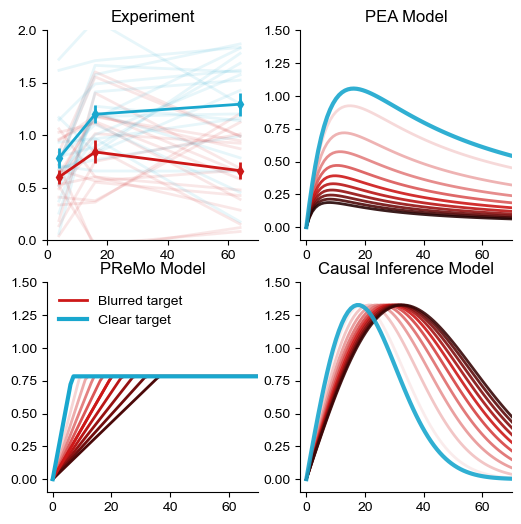

In [11]:
Deg = [4, 16, 64]
fig = plt.figure(figsize=(6, 6))

colr = np.array([205, 24, 24])/ 255
colb = np.array([25, 167, 206]) / 255
Axis = [0, 70, 0, 2]
s_v = np.linspace(0, 100, 100)
ratios = np.linspace(1.1, 3, 10)
Ratio = ratios[4]

# Experiment data

ax1 = fig.add_subplot(2, 2, 1)
ax1.set_xticks(np.arange(0, 101, 20))
ax1.axis(Axis)
ax1.set_title('Experiment', fontsize=12)
ax1.plot(Deg, absBlur.T, color=colr, linewidth=2,alpha=0.1)
ax1.plot(Deg, absClear.T, color=colb, linewidth=2,alpha=0.1)
ax1.errorbar(Deg, np.nanmean(absBlur, axis=0), np.std(absBlur, axis=0) / np.sqrt(absBlur.shape[0]), 
             linewidth=2,marker='d',markersize=5,
             capsize=0, markerfacecolor=colr, color=colr)
ax1.errorbar(Deg, np.nanmean(absClear, axis=0), np.std(absClear, axis=0) / np.sqrt(absClear.shape[0]), 
             marker='d', linewidth=2,markersize=5,
             capsize=0, markerfacecolor=colb, color=colb)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)


# simulation with PEA model

Axis = [-2, 70, -0.1, 1.5]
colr = np.array([205, 24, 24])/ 255
colb = np.array([25, 167, 206]) / 255
Step = 12
colmap = np.concatenate((np.linspace(1, colr[0], Step).reshape(-1, 1),
                         np.linspace(1, colr[1], Step).reshape(-1, 1),
                         np.linspace(1, colr[2], Step).reshape(-1, 1)), axis=1)
colmap = np.concatenate((colmap,
                         np.concatenate((np.linspace(colr[0], 0, Step).reshape(-1, 1),
                                         np.linspace(colr[1], 0, Step).reshape(-1, 1),
                                         np.linspace(colr[2], 0, Step).reshape(-1, 1)), axis=1)), axis=0)
colmap = np.delete(colmap, 10, axis=0)
sig_i = np.sqrt(21.17)
slope = 0.309
intercept = 1.853
B = 0.21
sig_v = slope * s_v + intercept
PEA_model_STL = B * s_v * (sig_i ** 2 / (sig_v ** 2 + sig_i ** 2))
PEA_Blur = np.zeros((len(ratios), len(s_v)))
for rs in range(len(ratios)):
    Ratio = ratios[rs]
    sig_v_Blur = (slope * s_v + intercept) * Ratio
    PEA_Blur[rs] = B * s_v * (sig_i ** 2 / (sig_v_Blur ** 2 + sig_i ** 2))
ax2 = fig.add_subplot(2, 2, 2)
for j in range(PEA_Blur.shape[0]):
    ax2.plot(s_v, PEA_Blur[j], color=colmap[2 + 2 * j,:], linewidth=2,alpha=0.9)
ax2.plot(s_v, PEA_model_STL, color=colb, linewidth=3,alpha=0.9)
ax2.set_xticks(np.arange(0, 101, 20))
ax2.axis(Axis)
ax2.set_title('PEA Model', fontsize=12)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)


# simulation with PReMo model

a_blur = 1 / (1 + (Ratio) ** 2 * (1 / 0.4361 - 1))
FitParams = [0.4361, 0.1424, 0.7238, 2.0756, 0.3774]
FitParams_blur = [a_blur, 0.1424, 0.7238, 2.0756, 0.3774]
PReMo_STL = np.zeros(len(s_v))
PReMo_STL_Blur = np.zeros(len(s_v))

for g in range(len(s_v)):
    PReMo_STL[g] = PReMoSTL_VU(FitParams, s_v[g])
    PReMo_STL_Blur[g] = PReMoSTL_VU(FitParams_blur, s_v[g])
PReMo_Blur = np.zeros((len(ratios), len(s_v)))

for rs in range(len(ratios)):
    Ratio = ratios[rs]
    a_blur = 1 / (1 + (Ratio) ** 2 * (1 / 0.4361 - 1))
    FitParams_blur = [a_blur, 0.1424, 0.7238, 2.0756, 0.3774]
    for i in range(len(s_v)):
        PReMo_Blur[rs, i] = PReMoSTL_VU(FitParams_blur, s_v[i])

ax3 = fig.add_subplot(2,2,3)
ax3.set_xticks(np.arange(0, 101, 20))
ax3.axis(Axis)
ax3.set_title('PReMo Model', fontsize=12)
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)
for j in range(PReMo_Blur.shape[0]):
    ax3.plot(s_v, PReMo_Blur[j], color=colmap[2 * j, :], linewidth=2)

b = []
b.append(ax3.plot(s_v, PReMo_Blur[5], color=colmap[2 * 5, :], linewidth=2)[0])
b.append(ax3.plot(s_v, PReMo_STL, color=colb, linewidth=3)[0])
ax3.legend(b, ['Blurred target','Clear target'], fontsize=10, loc='upper left', frameon=False)


# simulation with causal inference model

FitParams = [201.7668, 17.6013, 31.4169, 0.9486, 0.8544]
sp = 40
si = 17.6013
vp = np.sqrt(sp ** 2 * si ** 2 / (sp ** 2 - si ** 2))
Ratio = 2
Sigma_blur = np.sqrt(5 * Ratio ** 2 / (Ratio ** 2 + 4)) * si
FitParams_blur = [201.7668, Sigma_blur, 31.4169, 0.9486, 0.8544]
Rel_STL = np.zeros(len(s_v))
Rel_STL_Blur = np.zeros(len(s_v))

for g in range(len(s_v)):
    Rel_STL[g] = RelSTL_VU(FitParams, s_v[g])
    Rel_STL_Blur[g] = RelSTL_VU(FitParams_blur, s_v[g])
ratios = np.linspace(1.1, 3, 10)
Rel_Blur = np.zeros((len(ratios), len(s_v)))

for rs in range(len(ratios)):
    Ratio = ratios[rs]
    Sigma_blur = np.sqrt(5 * Ratio ** 2 / (Ratio ** 2 + 4)) * si
    FitParams_blur = [201.7668, Sigma_blur, 31.4169, 0.9486, 0.8544]
    for i in range(len(s_v)):
        Rel_Blur[rs, i] = RelSTL_VU(FitParams_blur, s_v[i])

ax4 = fig.add_subplot(2, 2, 4)
ax4.set_xticks(np.arange(0, 101, 20))
ax4.axis(Axis)
ax4.set_title('Causal Inference Model', fontsize=12)
ax4.spines['top'].set_visible(False)
ax4.spines['right'].set_visible(False)

for j in range(Rel_Blur.shape[0]):
    ax4.plot(s_v, Rel_Blur[j], color=np.append(colmap[1 + 2 * j, :], 0.9), linewidth=2)

ax4.plot(s_v, Rel_STL, color=np.append(colb, 0.9), linewidth=3)

plt.show()


### 4. Data fitting of [hand report](https://doi.org/10.1152/jn.00242.2020) (Figure 4A) 

**Import dataset and define functions**

In [2]:
def OutlierMAD(data, crit):
    MAD = 1.4862 * np.nanmedian(np.abs(data - np.nanmedian(data)))
    IsOutlier = np.abs(data - np.nanmedian(data)) > crit * MAD
    return IsOutlier

def ReportHand_Simu(param, pertur, trialNum):
    # see details in supplementary text1
    Hand_real = np.zeros(trialNum)
    Hand_report = np.zeros(trialNum)
    Hand_est = np.zeros(trialNum)
    a = param[0]
    b = param[1]
    R1 = param[2]
    R2 = param[3]

    for t in range(trialNum):
        s_v = -pertur[t]
        s_h = Hand_real[t]

        if not np.isnan(s_v):
            Hand_est[t] = R1 * s_v + R2 * s_h
            Hand_report[t] = R1 * s_v / (1 + R2) + 2 * R2 * s_h / (1 + R2)
        else:
            Hand_est[t] = R2 / (1 - R1) * s_h
            Hand_report[t] = (1 - R1) / (1 - R1 + R2) * Hand_est[t] + R2 / (1 - R1 + R2) * s_h

        if t < trialNum - 1:
            Hand_real[t + 1] = a * Hand_real[t] + b * (0 - Hand_est[t])

    return Hand_real, Hand_report, Hand_est

def ReportHand(param, pertur, ydata1, ydata2, Range):
    a = param[0]
    b = param[1]
    R1 = param[2]
    R2 = param[3]

    trialNum = len(ydata1)
    Hand_real = np.zeros(trialNum)
    Hand_report = np.zeros(trialNum)
    Hand_est = np.zeros(trialNum)

    for t in range(trialNum):
        s_v = -pertur[t]
        s_h = Hand_real[t]
        if not np.isnan(s_v):
            Hand_est[t] = R1 * s_v + R2 * s_h
            Hand_report[t] = R1 * s_v / (1 + R2) + 2 * R2 * s_h / (1 + R2)
        else:
            Hand_est[t] = R2 / (1 - R1) * s_h
            Hand_report[t] = (1 - R1) / (1 - R1 + R2) * Hand_est[t] + R2 / (1 - R1 + R2) * s_h
            
        if t < trialNum-1:
            Hand_real[t + 1] = a * Hand_real[t] + b * (0 - Hand_est[t])

    D1 = Hand_real[Range]
    D2 = Hand_report[Range]
    ydata1 = ydata1[Range]
    ydata2 = ydata2[Range]

    RMSE = np.sqrt(np.nanmean([(D1 - ydata1) ** 2, (D2 - ydata2) ** 2]))

    return RMSE

# load data
data = pd.read_csv("Tsay_report.csv")

Angle = np.abs(data['cond'][0])
sub = data['SN']
hand = data['hand_theta']
prop = data['hand_report']
Cond = data['cond']

Hand = []
Report = []
for s in range(1, max(sub)+1):
    if np.mean(Cond[sub == s]) > 0:
        d = -hand[sub == s].values
        r = -prop[sub == s].values
    else:
        d = hand[sub == s].values
        r = prop[sub == s].values
    IsOutlier = OutlierMAD(d, 2.5)
    d[IsOutlier] = np.nan
    # bin the data
    Hand.append(np.nanmean(np.reshape(d, (-1, 4)), axis=1))
    Report.append(np.nanmean(np.reshape(r, (-1, 4)), axis=1))

Hand = np.array(Hand)
Report = np.array(Report)

handreal = np.nanmean(Hand[:, 5:85], axis=0)
handreport = np.nanmean(Report[:, 5:85], axis=0)

**Data fitting and plot**

Note: since there is no equivalent optimization algorithm in Python to replace *fmincon* in Matlab. 
<br>
The fitting result could be slightly different from the paper, depends on the choice of algorithm and number of runs.

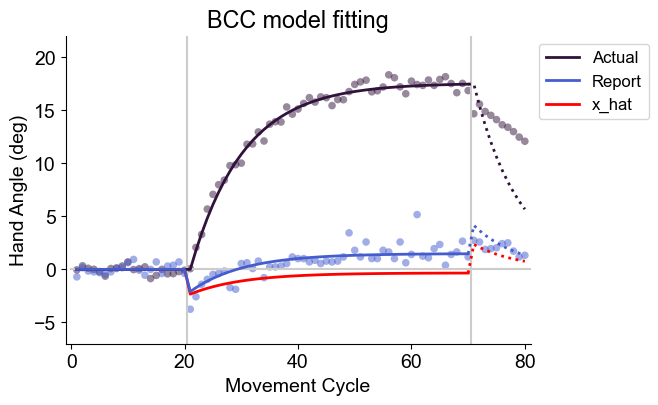

In [6]:
Range = np.arange(21, 71)
trialNum = len(handreal)
pertur = np.concatenate((np.zeros(20), np.ones(50) * Angle, np.full(10, np.nan)))

ini = [0.5, 0.2, 0.5, 0.5]
LB = [0.01, 0.01, 0.05, 0.05]
UB = [0.999, 0.999, 0.95, 0.95]
PLB = [0.6, 0.1, 0.1, 0.1]
PUB = [0.99, 0.6, 0.5, 0.5]

func = lambda x: ReportHand(x, pertur, handreal, handreport, Range)
FitParam = None
fval = float('inf')

# from pybads import BADS
# for run in range(10):
#     ini_run = [LB[i] + (UB[i] - LB[i]) * np.random.rand() for i in range(len(LB))]
#     bads = BADS(func, ini_run, LB, UB, PLB, PUB)
#     optimize_result = bads.optimize()
#     x_min = optimize_result['x']
#     Fval = optimize_result['fval']
#     if Fval < fval:
#         FitParam = x_min
#         fval = Fval

for run in range(500):
    ini_run = [LB[i] + (UB[i] - LB[i]) * np.random.rand() for i in range(len(LB))]
    res = minimize(func, ini_run, bounds=list(zip(LB, UB)))
    if res.fun < fval:
        FitParam = res.x
        fval = res.fun

handreal_sim, handreport_sim, handest_sim = ReportHand_Simu(FitParam, pertur, trialNum)

cols = plt.cm.turbo(np.linspace(0, 1, 20))
trialNum = len(handreal)

plt.figure(figsize=(6, 4), facecolor='w')
plt.rcParams['font.size'] = 14

plt.plot([0, trialNum+1], [0, 0], color=[0.8, 0.8, 0.8])
plt.plot([20.5, 20.5], [-10, 30], color=[0.8, 0.8, 0.8])
plt.plot([70.5, 70.5], [-10, 30], color=[0.8, 0.8, 0.8])

plt.scatter(np.arange(1, trialNum+1), handreal, s=30, marker='o', facecolors=cols[0], edgecolors='none', alpha=0.5)
plt.scatter(np.arange(1, trialNum+1), handreport, s=30, marker='o', facecolors=cols[2], edgecolors='none', alpha=0.5)

hhandPerc, = plt.plot(np.arange(1, 71), handest_sim[:70], color='r', linewidth=2)
hhand, = plt.plot(np.arange(1, 71), handreal_sim[:70], color=cols[0], linewidth=2)
hVerbal, = plt.plot(np.arange(1, 71), handreport_sim[:70], color=cols[2], linewidth=2)

plt.plot(np.arange(70, 81), handest_sim[69:81], color='r', linewidth=2, linestyle=':')
plt.plot(np.arange(70, 81), handreal_sim[69:81], color=cols[0], linewidth=2, linestyle=':')
plt.plot(np.arange(70, 81), handreport_sim[69:81], color=cols[2], linewidth=2, linestyle=':')

plt.title('BCC model fitting')
plt.xlabel('Movement Cycle')
plt.ylabel('Hand Angle (deg)')
plt.axis([-1, trialNum+1, -7, 22])
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.legend([hhand, hVerbal, hhandPerc], ['Actual', 'Report', 'x_hat'], loc='upper left', bbox_to_anchor=(1, 1), fontsize=12)

plt.show()